In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import BatchNormalization , GRU
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

2024-04-18 03:47:09.322432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 03:47:09.322613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 03:47:09.460068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


In [2]:
import os

ravdess = "/kaggle/input/ravdess-emotional-speech-audio"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

file_emotion = []
file_path = []

# Filter out directories that don't correspond to actor directories
actor_directories = [d for d in ravdess_directory_list if d.startswith('Actor_')]

for directory in actor_directories:
    actor_directory = os.path.join(ravdess, directory)  # Get the full path to the actor directory
    files = os.listdir(actor_directory)  # List all files for this actor
    for file in files:
        part = file.split('.')[0].split('-')
        # Ensure that the file name format is correct and contains at least three parts
        if len(part) >= 3:
            # Third part in each file represents the emotion associated with that file
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(actor_directory, file))  # Full path to the file
        else:
            print(f"Issue with filename: {file}")

# Now you have file_emotion and file_path populated with emotions and file paths respectively.


['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [3]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/A...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/A...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/A...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/A...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/A...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

/tmp/ipykernel_33/2539774017.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


In [4]:
# creating Dataframe using all the 4 dataframes we created so far.
# data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path = pd.concat([ravdess_df], axis = 0)
data_path.to_csv("classified_ravdess.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/A...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
data = pd.read_csv('/kaggle/working/classified_ravdess.csv')

# Specify the column you want to plot
column_to_plot = 'Emotions'

# Plotting box plot for the specific column
plt.figure(figsize=(10, 6))
sns.boxplot(x=data[column_to_plot])
plt.title('Box Plot of {}'.format(column_to_plot))
plt.xlabel('Values')
plt.ylabel('{}'.format(column_to_plot))
plt.xticks(rotation=45)
plt.show()

# Plotting violin plot for the specific column
plt.figure(figsize=(10, 6))
sns.violinplot(x=data[column_to_plot])
plt.title('Violin Plot of {}'.format(column_to_plot))
plt.xlabel('Values')
plt.ylabel('{}'.format(column_to_plot))
plt.xticks(rotation=45)
plt.show()


TypeError: Horizontal orientation requires numeric `x` variable.

<Figure size 1000x600 with 0 Axes>

In [6]:
import librosa
import numpy as np
import csv
import time
import pywt  # Adding import statement for pywt

def extract_features(audio_file):
    start_time = time.time()
    # Load audio file
    y, sr = librosa.load(audio_file)
    
    # Time-domain features
    mean = np.mean(y)
    variance = np.var(y)
    skewness = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    kurtosis = np.mean(librosa.feature.spectral_flatness(y=y))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    rms_energy = np.mean(librosa.feature.rms(y=y))
    
    # Intensity (average energy)
    intensity = np.mean(np.abs(y))
    
    # Pitch (fundamental frequency)
    pitch = librosa.piptrack(y=y, sr=sr)[0]
    pitch_freqs = [max(pitch[:, i]) for i in range(pitch.shape[1]) if max(pitch[:, i]) > 0]
    if pitch_freqs:
        pitch = np.mean(pitch_freqs)
    else:
        pitch = 0
    
    # Frequency-domain features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0].mean()
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0].mean()
    
    # Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_features = {f"chroma{i}": np.mean(chroma[i-1]) for i in range(1, chroma.shape[0] + 1)}
    
    # Spectral features
    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_density = np.sum(librosa.stft(y), axis=1)  # Summing up magnitudes across frequency bins
    
    # Extract each spectral flux coefficient separately
    spectralflux_features = {}
    for i, flux_value in enumerate(spectral_flux):
        spectralflux_features[f"spectralflux{i+1}"] = np.mean(flux_value)
    
    # Extract each spectral density coefficient separately
    spectraldes_features = {}
    for i, density_value in enumerate(spectral_density):
        spectraldes_features[f"spectraldes{i+1}"] = np.mean(density_value)
    
    # Extract each spectral flatness coefficient separately
    spectralflatness_features = {}
    for i, flatness_value in enumerate(spectral_flatness):
        for j, value in enumerate(flatness_value):
            spectralflatness_features[f"spectralflatness{j+1}_{i+1}"] = value
    
    # Wavelet transform (example code, may need customization)
    coeffs, _ = pywt.dwt(y, 'db1')  # Example of using wavelet transform (you might need to adjust parameters)
    
    # Extract each wavelet coefficient separately
    waveletcoeffs_features = {}
    for i, coeff_value in enumerate(coeffs):
        waveletcoeffs_features[f"waveletcoeff{i+1}"] = np.mean(coeff_value)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    # Extract each MFCC coefficient separately
    mfcc_features = {}
    for i in range(1, 14):
        mfcc_features[f"mfcc{i}"] = np.mean(mfccs[i-1])
    
    return {
        "mean": mean,
        "variance": variance,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "zero_crossing_rate": zero_crossing_rate,
        "rms_energy": rms_energy,
        "intensity": intensity,
        "pitch": pitch,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        **{f"spectralcontrast{i+1}": spectral_contrast[i] for i in range(len(spectral_contrast))},  # Unpack Spectral contrast features
        "spectral_rolloff": spectral_rolloff,
        **mfcc_features,  # Unpack MFCC coefficients
        **chroma_features,  # Unpack Chroma features
        **spectralflux_features,  # Unpack Spectral flux features
        **spectraldes_features,  # Unpack Spectral density features
        **spectralflatness_features,  # Unpack Spectral flatness features
        "time_taken": time_taken
    }
# Read audio file paths and their corresponding emotion labels from CSV
def read_audio_paths(csv_file):
    audio_paths = []
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            audio_paths.append((row['Path'], row['Emotions']))  # Assuming 'Path' and 'Emotion' are the column names
    return audio_paths

# Example usage:
csv_file = "/kaggle/working/classified_ravdess.csv"
audio_paths = read_audio_paths(csv_file)

# List to store features of all audio files
all_features = []

# Start time for the entire dataset
total_start_time = time.time()

# Extract features for each audio file
for audio_path, emotion_label in audio_paths:
    features = extract_features(audio_path)
    features["Path"] = audio_path
    features["Emotions"] = emotion_label
    all_features.append(features)

# End time for the entire dataset
total_end_time = time.time()

# Total time taken for the entire dataset
total_time_taken = total_end_time - total_start_time

# Collect all feature names
all_feature_names = set()
for features in all_features:
    all_feature_names.update(features.keys())

# Create fieldnames list
fieldnames = list(all_feature_names)

# Write features to CSV file
output_csv_file = "ravdessfeatures.csv"
with open(output_csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_features)

print("Features extracted and stored in:", output_csv_file)
print("Total time taken for the entire dataset:", total_time_taken, "seconds")

Features extracted and stored in: ravdessfeatures.csv
Total time taken for the entire dataset: 1435.2879178524017 seconds


In [7]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("/kaggle/working/ravdessfeatures.csv")

# Get the number of rows and columns
num_rows, num_cols = df.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 1440
Number of columns: 1527


In [8]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/ravdessfeatures.csv"
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()

,spectraldes738,chroma9,spectraldes983,spectraldes449,spectraldes207,spectraldes36,spectralflatness89_1,spectralflux15,spectraldes234,spectraldes328,...,spectraldes104,spectralflux7,spectraldes495,spectraldes639,spectraldes224,spectraldes574,spectraldes422,spectraldes626,spectralflatness44_1,spectraldes1003
0,(-0.04471788+0.4329297j),0.427161,(5.6928584e-06-1.42205245e-05j),(0.701622-1.2647849j),(-1.2995588e-07+7.281502e-05j),(7.016406+3.9125433j),0.004743,0.0,(1.1291955-0.8289414j),(1.8011165-0.6991974j),...,(-0.9097474+12.100191j),0.0,(-5.392285e-07-4.1998108e-05j),(-0.000109964036-6.473243e-05j),(1.2473687-0.7878716j),(1.669126+0.71367246j),(-0.23756164+0.2333308j),(-0.4930589-0.6017576j),0.257979,(8.754937e-07-1.9999293e-06j)
1,(0.029397415+0.17767769j),0.450711,(1.07717824e-07+1.2916884e-05j),(0.5788757+0.20377055j),(0.00014864498-0.00027122215j),(3.9044003-2.7709765j),0.000881,0.0,(0.5913661-0.040063467j),(0.37839144+0.24376316j),...,(1.0527154+1.2935661j),0.0,(5.4451135e-05+2.2239423e-05j),(-6.1004335e-05-9.582367e-06j),(0.4707532+0.044851705j),(0.0008276108-0.19890946j),(0.5090396+0.18752977j),(-0.16005985-0.10531379j),0.182214,(2.0302298e-07+3.2911084e-06j)
2,(-0.037054446+0.12402327j),0.524493,(-6.058759e-06+2.644051e-05j),(-0.042073768+0.11468975j),(-7.721261e-06+8.019662e-05j),(-1.6289098+1.2362852j),0.006940,0.0,(0.92188686+0.1625813j),(-0.38759577-0.116730824j),...,(-6.3290644-16.952848j),0.0,(-4.062157e-05+4.809833e-05j),(-1.7308497e-05+8.102172e-06j),(-0.19064845-0.8075348j),(-0.097485796-0.39045203j),(0.3453798+0.3799081j),(-0.19096458+0.6433648j),0.212514,(-3.3851425e-06+1.1764996e-07j)
3,(0.046468776-0.12925191j),0.471353,(1.3831541e-05+3.845452e-05j),(0.052738335-0.94488716j),(7.9989986e-05-0.00012251106j),(-6.814944-1.5417802j),0.000718,0.0,(-0.30046716+0.12437279j),(-0.36158067+0.5523175j),...,(-0.028739505+2.187557j),0.0,(-3.6498466e-05+1.231514e-05j),(1.7059501e-05-0.00011178714j),(0.01849244-0.21115042j),(0.08090432-0.014911341j),(0.17119549-0.37705162j),(0.07500544-0.06922975j),0.129047,(1.1596395e-05-3.7067225e-06j)
4,(0.18339024+0.08557633j),0.502221,(-2.3387212e-05+1.0928072e-05j),(-0.5083925+0.3313562j),(1.0274067e-05-8.7527784e-05j),(-5.912557+2.4257195j),0.001108,0.0,(-1.0947592-0.33871806j),(1.1183503+0.52434015j),...,(-3.030559-6.033703j),0.0,(2.523448e-05-7.962383e-05j),(0.0001250988-6.0447448e-05j),(0.22083965+0.18718906j),(0.41273552+0.4336396j),(-0.32957804+0.35464624j),(0.065937504-0.35787466j),0.134680,(-1.4184974e-05-1.2644656e-05j)


In [9]:
import pandas as pd

# Read the CSV file
input_file = "/kaggle/working/ravdessfeatures.csv"
output_file = "ravdess_features.csv"

data = pd.read_csv(input_file)

# Define the character you want to remove
character_to_remove = "("

# Remove the specified character from the DataFrame
data = data.applymap(lambda x: x.replace(character_to_remove, '') if isinstance(x, str) else x)

# Write the modified DataFrame back to a new CSV file
data.to_csv(output_file, index=False)

print("Character '{}' removed from the CSV file.".format(character_to_remove))


Character '(' removed from the CSV file.


In [10]:
import pandas as pd

# Read the CSV file
input_file = "/kaggle/working/ravdess_features.csv"
output_file = "ravdess_extracted_feature.csv"

data = pd.read_csv(input_file)

# Define the character you want to remove
character_to_remove = ")"

# Remove the specified character from the DataFrame
data = data.applymap(lambda x: x.replace(character_to_remove, '') if isinstance(x, str) else x)

# Write the modified DataFrame back to a new CSV file
data.to_csv(output_file, index=False)

print("Character '{}' removed from the CSV file.".format(character_to_remove))


Character ')' removed from the CSV file.


In [11]:
import pandas as pd

# Read the CSV file
input_file = "/kaggle/working/ravdess_extracted_feature.csv"
output_file = "LibrosaExtractedFeaturesRavdess.csv"

data = pd.read_csv(input_file)

# Define the alphabet you want to remove
alphabet_to_remove = 'j'

# Remove the specified alphabet from the DataFrame
data = data.applymap(lambda x: x.replace(alphabet_to_remove, '') if isinstance(x, str) else x)

# Write the modified DataFrame back to a new CSV file
data.to_csv(output_file, index=False)

print("Alphabet '{}' removed from the CSV file.".format(alphabet_to_remove))


Alphabet 'j' removed from the CSV file.


In [12]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/LibrosaExtractedFeaturesRavdess.csv"
outputfile = ""
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,spectraldes738,chroma9,spectraldes983,spectraldes449,spectraldes207,spectraldes36,spectralflatness89_1,spectralflux15,spectraldes234,spectraldes328,...,spectraldes104,spectralflux7,spectraldes495,spectraldes639,spectraldes224,spectraldes574,spectraldes422,spectraldes626,spectralflatness44_1,spectraldes1003
0,-0.04471788+0.4329297,0.427161,5.6928584e-06-1.42205245e-05,0.701622-1.2647849,-1.2995588e-07+7.281502e-05,7.016406+3.9125433,0.004743,0.0,1.1291955-0.8289414,1.8011165-0.6991974,...,-0.9097474+12.100191,0.0,-5.392285e-07-4.1998108e-05,-0.000109964036-6.473243e-05,1.2473687-0.7878716,1.669126+0.71367246,-0.23756164+0.2333308,-0.4930589-0.6017576,0.257979,8.754937e-07-1.9999293e-06
1,0.029397415+0.17767769,0.450711,1.07717824e-07+1.2916884e-05,0.5788757+0.20377055,0.00014864498-0.00027122215,3.9044003-2.7709765,0.000881,0.0,0.5913661-0.040063467,0.37839144+0.24376316,...,1.0527154+1.2935661,0.0,5.4451135e-05+2.2239423e-05,-6.1004335e-05-9.582367e-06,0.4707532+0.044851705,0.0008276108-0.19890946,0.5090396+0.18752977,-0.16005985-0.10531379,0.182214,2.0302298e-07+3.2911084e-06
2,-0.037054446+0.12402327,0.524493,-6.058759e-06+2.644051e-05,-0.042073768+0.11468975,-7.721261e-06+8.019662e-05,-1.6289098+1.2362852,0.006940,0.0,0.92188686+0.1625813,-0.38759577-0.116730824,...,-6.3290644-16.952848,0.0,-4.062157e-05+4.809833e-05,-1.7308497e-05+8.102172e-06,-0.19064845-0.8075348,-0.097485796-0.39045203,0.3453798+0.3799081,-0.19096458+0.6433648,0.212514,-3.3851425e-06+1.1764996e-07
3,0.046468776-0.12925191,0.471353,1.3831541e-05+3.845452e-05,0.052738335-0.94488716,7.9989986e-05-0.00012251106,-6.814944-1.5417802,0.000718,0.0,-0.30046716+0.12437279,-0.36158067+0.5523175,...,-0.028739505+2.187557,0.0,-3.6498466e-05+1.231514e-05,1.7059501e-05-0.00011178714,0.01849244-0.21115042,0.08090432-0.014911341,0.17119549-0.37705162,0.07500544-0.06922975,0.129047,1.1596395e-05-3.7067225e-06
4,0.18339024+0.08557633,0.502221,-2.3387212e-05+1.0928072e-05,-0.5083925+0.3313562,1.0274067e-05-8.7527784e-05,-5.912557+2.4257195,0.001108,0.0,-1.0947592-0.33871806,1.1183503+0.52434015,...,-3.030559-6.033703,0.0,2.523448e-05-7.962383e-05,0.0001250988-6.0447448e-05,0.22083965+0.18718906,0.41273552+0.4336396,-0.32957804+0.35464624,0.065937504-0.35787466,0.134680,-1.4184974e-05-1.2644656e-05


In [14]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/working/LibrosaExtractedFeaturesRavdess.csv')

# Iterate over each cell in the DataFrame
for column in df.columns:
    df[column] = df[column].apply(lambda x: '=' + x if isinstance(x, str) and not x.startswith('=') else x)

# Save the modified DataFrame back to a new CSV file
df.to_csv('output_file_ravdess.csv', index=False)


In [15]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/output_file_ravdess.csv"
outputfile = ""
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,spectraldes738,chroma9,spectraldes983,spectraldes449,spectraldes207,spectraldes36,spectralflatness89_1,spectralflux15,spectraldes234,spectraldes328,...,spectraldes104,spectralflux7,spectraldes495,spectraldes639,spectraldes224,spectraldes574,spectraldes422,spectraldes626,spectralflatness44_1,spectraldes1003
0,=-0.04471788+0.4329297,0.427161,=5.6928584e-06-1.42205245e-05,=0.701622-1.2647849,=-1.2995588e-07+7.281502e-05,=7.016406+3.9125433,0.004743,0.0,=1.1291955-0.8289414,=1.8011165-0.6991974,...,=-0.9097474+12.100191,0.0,=-5.392285e-07-4.1998108e-05,=-0.000109964036-6.473243e-05,=1.2473687-0.7878716,=1.669126+0.71367246,=-0.23756164+0.2333308,=-0.4930589-0.6017576,0.257979,=8.754937e-07-1.9999293e-06
1,=0.029397415+0.17767769,0.450711,=1.07717824e-07+1.2916884e-05,=0.5788757+0.20377055,=0.00014864498-0.00027122215,=3.9044003-2.7709765,0.000881,0.0,=0.5913661-0.040063467,=0.37839144+0.24376316,...,=1.0527154+1.2935661,0.0,=5.4451135e-05+2.2239423e-05,=-6.1004335e-05-9.582367e-06,=0.4707532+0.044851705,=0.0008276108-0.19890946,=0.5090396+0.18752977,=-0.16005985-0.10531379,0.182214,=2.0302298e-07+3.2911084e-06
2,=-0.037054446+0.12402327,0.524493,=-6.058759e-06+2.644051e-05,=-0.042073768+0.11468975,=-7.721261e-06+8.019662e-05,=-1.6289098+1.2362852,0.006940,0.0,=0.92188686+0.1625813,=-0.38759577-0.116730824,...,=-6.3290644-16.952848,0.0,=-4.062157e-05+4.809833e-05,=-1.7308497e-05+8.102172e-06,=-0.19064845-0.8075348,=-0.097485796-0.39045203,=0.3453798+0.3799081,=-0.19096458+0.6433648,0.212514,=-3.3851425e-06+1.1764996e-07
3,=0.046468776-0.12925191,0.471353,=1.3831541e-05+3.845452e-05,=0.052738335-0.94488716,=7.9989986e-05-0.00012251106,=-6.814944-1.5417802,0.000718,0.0,=-0.30046716+0.12437279,=-0.36158067+0.5523175,...,=-0.028739505+2.187557,0.0,=-3.6498466e-05+1.231514e-05,=1.7059501e-05-0.00011178714,=0.01849244-0.21115042,=0.08090432-0.014911341,=0.17119549-0.37705162,=0.07500544-0.06922975,0.129047,=1.1596395e-05-3.7067225e-06
4,=0.18339024+0.08557633,0.502221,=-2.3387212e-05+1.0928072e-05,=-0.5083925+0.3313562,=1.0274067e-05-8.7527784e-05,=-5.912557+2.4257195,0.001108,0.0,=-1.0947592-0.33871806,=1.1183503+0.52434015,...,=-3.030559-6.033703,0.0,=2.523448e-05-7.962383e-05,=0.0001250988-6.0447448e-05,=0.22083965+0.18718906,=0.41273552+0.4336396,=-0.32957804+0.35464624,=0.065937504-0.35787466,0.134680,=-1.4184974e-05-1.2644656e-05


In [4]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/input/outputfile-ravdess/output_file_ravdess.csv"
outputfile = ""
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,spectraldes738,chroma9,spectraldes983,spectraldes449,spectraldes207,spectraldes36,spectralflatness89_1,spectralflux15,spectraldes234,spectraldes328,...,spectraldes104,spectralflux7,spectraldes495,spectraldes639,spectraldes224,spectraldes574,spectraldes422,spectraldes626,spectralflatness44_1,spectraldes1003
0,0.388212,0.427161,-0.000009,-0.563163,0.000073,10.928949,0.004743,0.0,0.300254,1.101919,...,11.190444,0.0,-0.000043,-0.000175,0.459497,2.382798,-0.004231,-1.094817,0.257979,-0.000001
1,0.207075,0.450711,0.000013,0.782646,-0.000123,1.133424,0.000881,0.0,0.551303,0.622155,...,2.346281,0.0,0.000077,-0.000071,0.515605,-0.198082,0.696569,-0.265374,0.182214,0.000003
2,0.086969,0.524493,0.000020,0.072616,0.000072,-0.392625,0.006940,0.0,1.084468,-0.504327,...,-23.281912,0.0,0.000007,-0.000009,-0.998183,-0.487938,0.725288,0.452400,0.212514,-0.000003
3,-0.082783,0.471353,0.000052,-0.892149,-0.000043,-8.356724,0.000718,0.0,-0.176094,0.190737,...,2.158817,0.0,-0.000024,-0.000095,-0.192658,0.065993,-0.205856,0.005776,0.129047,0.000008
4,0.268967,0.502221,-0.000012,-0.177036,-0.000077,-3.486838,0.001108,0.0,-1.433477,1.642690,...,-9.064262,0.0,-0.000054,0.000065,0.408029,0.846375,0.025068,-0.291937,0.134680,-0.000027


In [5]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/input/outputfile-ravdess/output_file_ravdess.csv')

# Drop a specific column
column_to_drop = 'Path'
df.drop(column_to_drop, axis=1, inplace=True)


# You can also save the modified DataFrame back to a CSV file if needed
df.to_csv('ExtractedFeaturesForRavdessDataset.csv', index=False)


In [6]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/working/ExtractedFeaturesForRavdessDataset.csv')

# Convert string values to float for all columns
for column in df.columns:
    # Check if the column contains string values
    if df[column].dtype == 'object':
        # Use try-except to handle potential conversion errors
        try:
            df[column] = df[column].str.replace(',', '').astype(float)
            # If your string values contain commas as thousands separators, remove them with .str.replace(',', '')
        except ValueError:
            print(f"Unable to convert values in column '{column}' to float.")

# Now, string values that could be converted to float have been converted.
# If any value couldn't be converted, it remains as is.

# You can also save the modified DataFrame back to a CSV file if needed
# df.to_csv('output_file.csv', index=False)


Unable to convert values in column 'Emotions' to float.


In [7]:
import pandas as pd

# Read the first CSV file
csv1 = pd.read_csv("/kaggle/input/classifieddata/classified_ravdess.csv")

# Read the second CSV file
csv2 = pd.read_csv("/kaggle/working/ExtractedFeaturesForRavdessDataset.csv")

# Copy the 'Emotions' column from csv1 to csv2
csv2['Emotions'] = csv1['Emotions']

# Save the modified csv2 to a new CSV file
csv2.to_csv("/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosa.csv", index=False)

print("Emotions column copied from csv1 to csv2 and saved to output.csv")


Emotions column copied from csv1 to csv2 and saved to output.csv


In [8]:
import pandas as pd

# Read CSV file
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosa.csv')

# Check unique values in the 'Emotions' column
unique_emotions = data['Emotions'].unique()

# Print unique values
print("Unique values in the 'Emotions' column:")
print(unique_emotions)


Unique values in the 'Emotions' column:
['surprise' 'neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']


In [9]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosa.csv')

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Now, save the DataFrame back to a CSV file if needed
data.to_csv('/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csvv', index=False)


In [10]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csvv"
outputfile = ""
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,spectraldes738,chroma9,spectraldes983,spectraldes449,spectraldes207,spectraldes36,spectralflatness89_1,spectralflux15,spectraldes234,spectraldes328,...,spectraldes104,spectralflux7,spectraldes495,spectraldes639,spectraldes224,spectraldes574,spectraldes422,spectraldes626,spectralflatness44_1,spectraldes1003
0,0.388212,0.427161,-0.000009,-0.563163,0.000073,10.928949,0.004743,0.0,0.300254,1.101919,...,11.190444,0.0,-0.000043,-0.000175,0.459497,2.382798,-0.004231,-1.094817,0.257979,-0.000001
1,0.207075,0.450711,0.000013,0.782646,-0.000123,1.133424,0.000881,0.0,0.551303,0.622155,...,2.346281,0.0,0.000077,-0.000071,0.515605,-0.198082,0.696569,-0.265374,0.182214,0.000003
2,0.086969,0.524493,0.000020,0.072616,0.000072,-0.392625,0.006940,0.0,1.084468,-0.504327,...,-23.281912,0.0,0.000007,-0.000009,-0.998183,-0.487938,0.725288,0.452400,0.212514,-0.000003
3,-0.082783,0.471353,0.000052,-0.892149,-0.000043,-8.356724,0.000718,0.0,-0.176094,0.190737,...,2.158817,0.0,-0.000024,-0.000095,-0.192658,0.065993,-0.205856,0.005776,0.129047,0.000008
4,0.268967,0.502221,-0.000012,-0.177036,-0.000077,-3.486838,0.001108,0.0,-1.433477,1.642690,...,-9.064262,0.0,-0.000054,0.000065,0.408029,0.846375,0.025068,-0.291937,0.134680,-0.000027


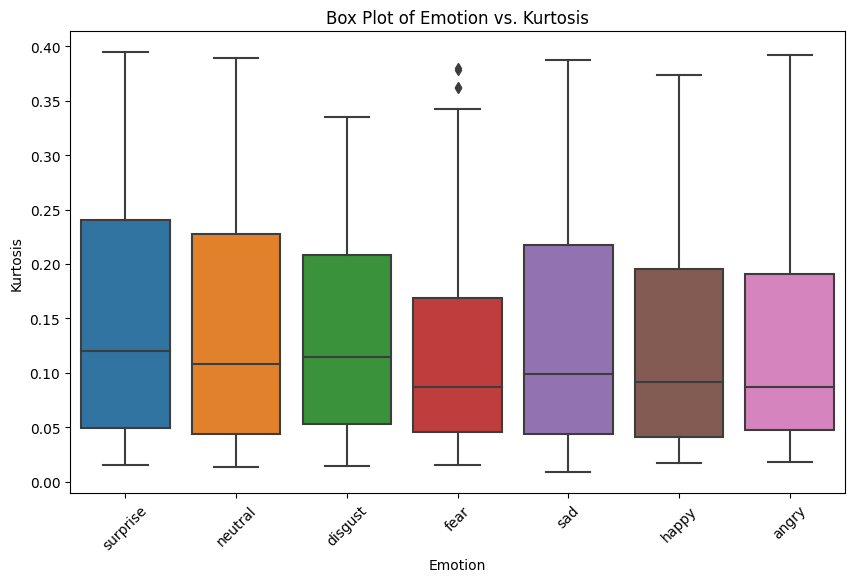

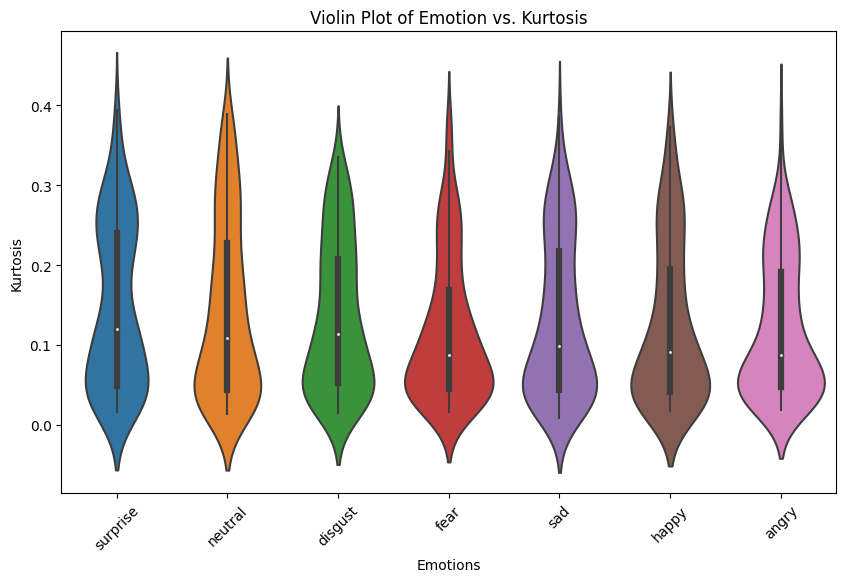

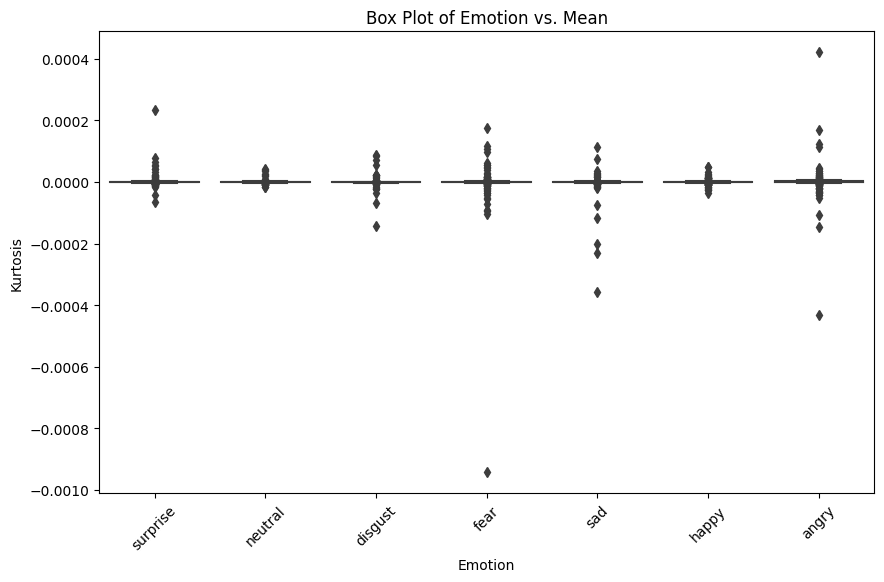

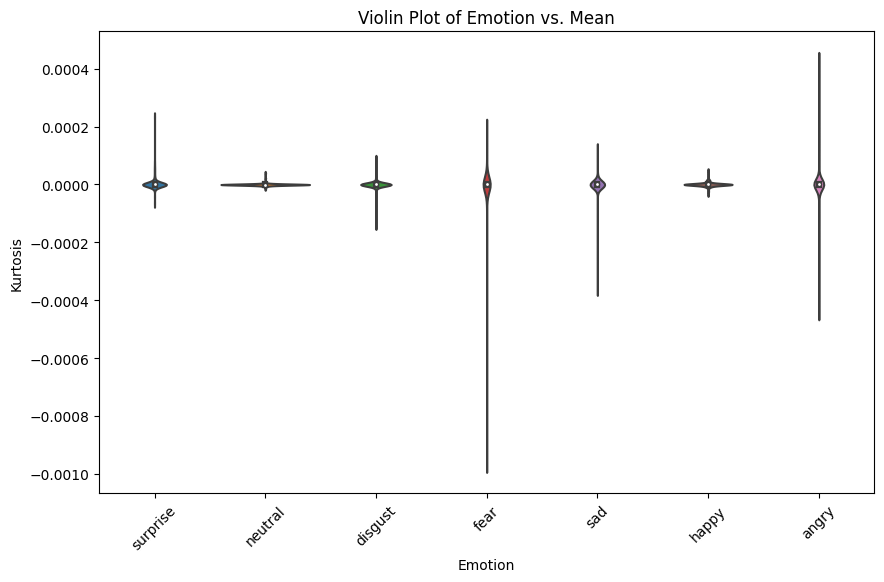

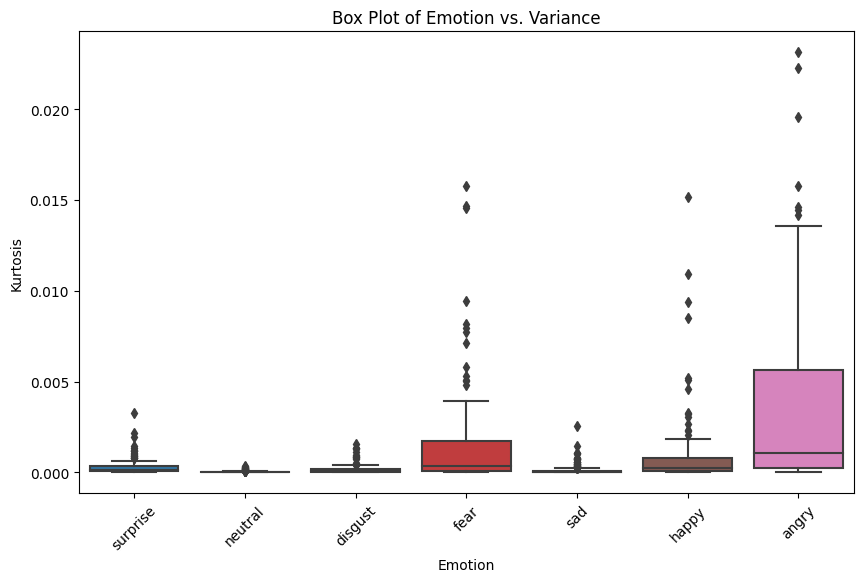

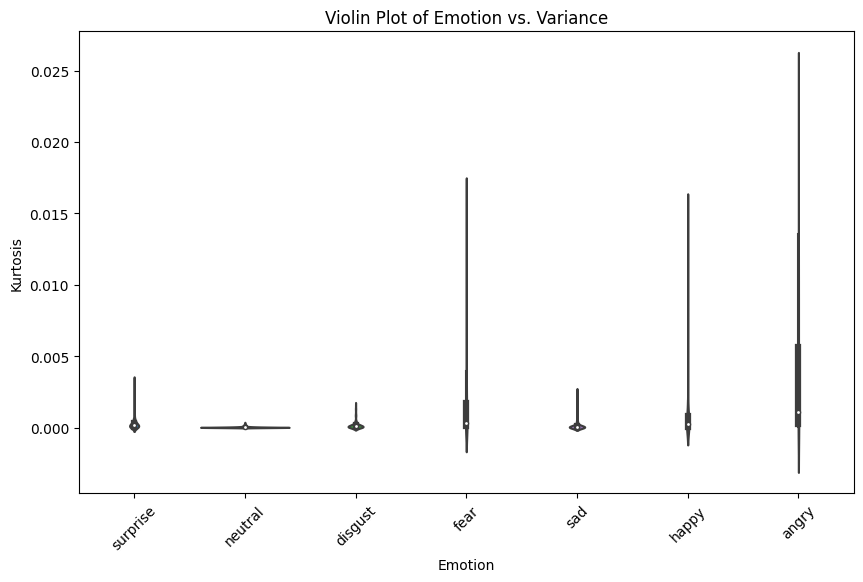

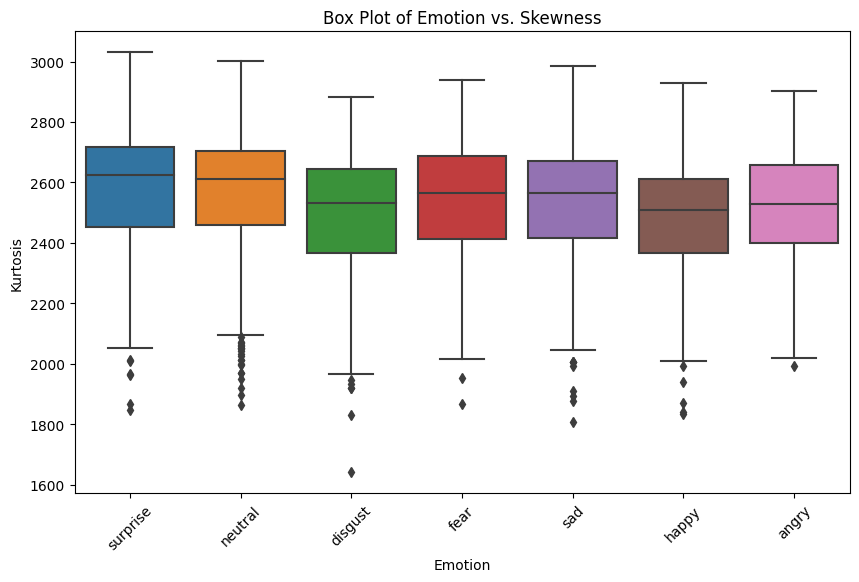

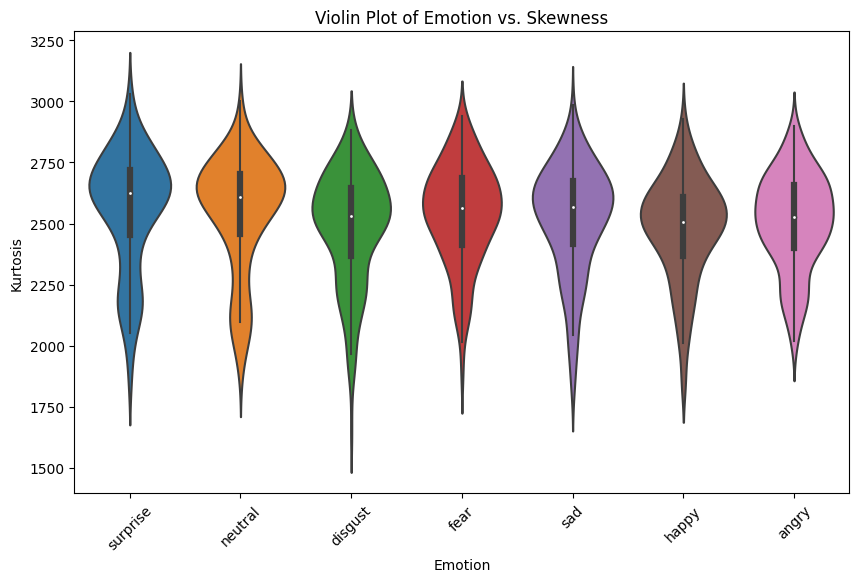

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csvv')

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='kurtosis', data=data)
plt.title('Box Plot of Emotion vs. Kurtosis')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='kurtosis', data=data)
plt.title('Violin Plot of Emotion vs. Kurtosis')
plt.xlabel('Emotions')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='mean', data=data)
plt.title('Box Plot of Emotion vs. Mean')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='mean', data=data)
plt.title('Violin Plot of Emotion vs. Mean')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()


# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='variance', data=data)
plt.title('Box Plot of Emotion vs. Variance')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='variance', data=data)
plt.title('Violin Plot of Emotion vs. Variance')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()


# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='skewness', data=data)
plt.title('Box Plot of Emotion vs. Skewness')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='skewness', data=data)
plt.title('Violin Plot of Emotion vs. Skewness')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time

# Load data from CSV
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-04-18 16:03:09.471958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 16:03:09.472259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 16:03:09.692935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-pac

Logistic Regression: Accuracy = 0.3264, Precision = 0.2785, Recall = 0.3264, F1 Score = 0.2800, Training Time = 2.1172 s, Prediction Time = 0.1272 s
Naive Bayes: Accuracy = 0.3819, Precision = 0.3591, Recall = 0.3819, F1 Score = 0.3474, Training Time = 0.1678 s, Prediction Time = 0.0608 s
Decision Tree: Accuracy = 0.3021, Precision = 0.3143, Recall = 0.3021, F1 Score = 0.3055, Training Time = 1.6986 s, Prediction Time = 0.0376 s
Random Forest: Accuracy = 0.4375, Precision = 0.4146, Recall = 0.4375, F1 Score = 0.4035, Training Time = 3.5694 s, Prediction Time = 0.0533 s
KNN: Accuracy = 0.2743, Precision = 0.2463, Recall = 0.2743, F1 Score = 0.2470, Training Time = 0.0592 s, Prediction Time = 0.2481 s
Gradient Boosting: Accuracy = 0.5104, Precision = 0.5044, Recall = 0.5104, F1 Score = 0.5009, Training Time = 372.2324 s, Prediction Time = 0.0546 s
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Feedforward Neural Network: Accuracy = 0.4410, Precision = 0.4359, Recall = 0.4410, F1 Score = 0.4295, T

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier: Accuracy = 0.4583, Precision = 0.4311, Recall = 0.4583, F1 Score = 0.4170, Training Time = 385.2786 s, Prediction Time = 0.3984 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),  # Add XGBoost model
    'LightGBM': lgb.LGBMClassifier()  # Add LightGBM model
    # Rest of the models remain the same
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(max_iter=1000)),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.3403, Precision = 0.3132, Recall = 0.3403, F1 Score = 0.3101, Training Time = 19.4166 s, Prediction Time = 0.0867 s
Naive Bayes: Accuracy = 0.3819, Precision = 0.3591, Recall = 0.3819, F1 Score = 0.3474, Training Time = 0.1285 s, Prediction Time = 0.0546 s
Decision Tree: Accuracy = 0.3403, Precision = 0.3572, Recall = 0.3403, F1 Score = 0.3461, Training Time = 1.7352 s, Prediction Time = 0.0374 s
Random Forest: Accuracy = 0.4583, Precision = 0.4338, Recall = 0.4583, F1 Score = 0.4242, Training Time = 3.6570 s, Prediction Time = 0.0530 s
KNN: Accuracy = 0.2743, Precision = 0.2463, Recall = 0.2743, F1 Score = 0.2470, Training Time = 0.0539 s, Prediction Time = 0.0880 s
Gradient Boosting: Accuracy = 0.5174, Precision = 0.5100, Recall = 0.5174, F1 Score = 0.5078, Training Time = 366.3957 s, Prediction Time = 0.0479 s
XGBoost: Accuracy = 0.5312, Precision = 0.5152, Recall = 0.5312, F1 Score = 0.5124, Training Time = 59.7684 s, Prediction Time = 0.2426 s
[Li

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier: Accuracy = 0.4618, Precision = 0.4399, Recall = 0.4618, F1 Score = 0.4213, Training Time = 392.5543 s, Prediction Time = 0.3909 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),  # Add XGBoost model
    'LightGBM': lgb.LGBMClassifier()  # Add LightGBM model
    # Rest of the models remain the same
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.3403, Precision = 0.3132, Recall = 0.3403, F1 Score = 0.3101, Training Time = 17.7364 s, Prediction Time = 0.1288 s
Naive Bayes: Accuracy = 0.3819, Precision = 0.3591, Recall = 0.3819, F1 Score = 0.3474, Training Time = 0.1275 s, Prediction Time = 0.0569 s
Decision Tree: Accuracy = 0.3229, Precision = 0.3336, Recall = 0.3229, F1 Score = 0.3245, Training Time = 1.7710 s, Prediction Time = 0.0350 s
Random Forest: Accuracy = 0.4306, Precision = 0.4089, Recall = 0.4306, F1 Score = 0.4001, Training Time = 3.5993 s, Prediction Time = 0.0506 s
KNN: Accuracy = 0.2743, Precision = 0.2463, Recall = 0.2743, F1 Score = 0.2470, Training Time = 0.0504 s, Prediction Time = 0.0966 s
Gradient Boosting: Accuracy = 0.5243, Precision = 0.5280, Recall = 0.5243, F1 Score = 0.5174, Training Time = 365.4907 s, Prediction Time = 0.0467 s
XGBoost: Accuracy = 0.5312, Precision = 0.5152, Recall = 0.5312, F1 Score = 0.5124, Training Time = 86.2239 s, Prediction Time = 0.2480 s
[Li

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier: Accuracy = 0.4375, Precision = 0.4031, Recall = 0.4375, F1 Score = 0.3945, Training Time = 388.9106 s, Prediction Time = 0.3887 s


LDA

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize LDA
lda = LDA()

# Fit LDA on the training data and transform both training and test data
X_train_lda = lda.fit_transform(X_train_scaled, y_train_encoded)
X_test_lda = lda.transform(X_test_scaled)

# Display the number of components retained after LDA
print(f'Number of components retained after LDA: {lda.explained_variance_ratio_.shape[0]}')

# Reshape data for CNN input after LDA
X_train_lda_cnn = X_train_lda.reshape(X_train_lda.shape[0], X_train_lda.shape[1], 1)
X_test_lda_cnn = X_test_lda.reshape(X_test_lda.shape[0], X_test_lda.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_lda_cnn.shape[1], X_train_lda_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with LDA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_lda, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_lda)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_lda)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with LDA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-04 15:43:26.562848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 15:43:26.562986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 15:43:26.742351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of components retained after LDA: 6


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Logistic Regression with LDA: Accuracy = 0.2778, Precision = 0.2944, Recall = 0.2778, F1 Score = 0.2779, Training Time = 0.0271 s, Prediction Time = 0.0003 s
Naive Bayes with LDA: Accuracy = 0.2292, Precision = 0.2826, Recall = 0.2292, F1 Score = 0.2213, Training Time = 0.0020 s, Prediction Time = 0.0005 s
Decision Tree with LDA: Accuracy = 0.1979, Precision = 0.2212, Recall = 0.1979, F1 Score = 0.1861, Training Time = 0.0061 s, Prediction Time = 0.0008 s
Random Forest with LDA: Accuracy = 0.2188, Precision = 0.2368, Recall = 0.2188, F1 Score = 0.2196, Training Time = 0.2736 s, Prediction Time = 0.0100 s
KNN with LDA: Accuracy = 0.2812, Precision = 0.2886, Recall = 0.2812, F1 Score = 0.2821, Training Time = 0.0026 s, Prediction Time = 0.0224 s
Gradient Boosting with LDA: Accuracy = 0.2535, Precision = 0.2631, Recall = 0.2535, F1 Score = 0.2497, Training Time = 2.5556 s, Prediction Time = 0.0054 s
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feedforward Neural Network with LDA: Accuracy = 0.26

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


pca

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA
pca = PCA(n_components=0.99)  # Retain 95% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, objective='multi:softmax'),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=5, objective='multiclass'),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Number of components retained after PCA: 129


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.2674, Precision = 0.2537, Recall = 0.2674, F1 Score = 0.2518, Training Time = 0.1522 s, Prediction Time = 0.0005 s
Naive Bayes with PCA: Accuracy = 0.3125, Precision = 0.2706, Recall = 0.3125, F1 Score = 0.2422, Training Time = 0.0051 s, Prediction Time = 0.0022 s
Decision Tree with PCA: Accuracy = 0.3056, Precision = 0.2864, Recall = 0.3056, F1 Score = 0.2724, Training Time = 0.1219 s, Prediction Time = 0.0004 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest with PCA: Accuracy = 0.3333, Precision = 0.3058, Recall = 0.3333, F1 Score = 0.2718, Training Time = 0.7050 s, Prediction Time = 0.0087 s
KNN with PCA: Accuracy = 0.2500, Precision = 0.2161, Recall = 0.2500, F1 Score = 0.2057, Training Time = 0.0013 s, Prediction Time = 0.0204 s
Gradient Boosting with PCA: Accuracy = 0.3819, Precision = 0.3614, Recall = 0.3819, F1 Score = 0.3619, Training Time = 34.7406 s, Prediction Time = 0.0062 s
XGBoost with PCA: Accuracy = 0.3611, Precision = 0.3376, Recall = 0.3611, F1 Score = 0.3407, Training Time = 7.9718 s, Prediction Time = 0.0077 s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003382 seconds.
You can set `force_col_wise=true` to re

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier with PCA: Accuracy = 0.3646, Precision = 0.3569, Recall = 0.3646, F1 Score = 0.3099, Training Time = 35.7626 s, Prediction Time = 0.0389 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier with PCA: Accuracy = 0.3472, Precision = 0.3053, Recall = 0.3472, F1 Score = 0.3112, Training Time = 179.6770 s, Prediction Time = 0.0392 s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier with PCA: Accuracy = 0.2882, Precision = 0.2717, Recall = 0.2882, F1 Score = 0.2756, Training Time = 1.2476 s, Prediction Time = 0.0039 s


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, objective='multi:softmax'),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=5, objective='multiclass'),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Number of components retained after PCA: 19


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.2292, Precision = 0.2024, Recall = 0.2292, F1 Score = 0.1746, Training Time = 0.0712 s, Prediction Time = 0.0008 s
Naive Bayes with PCA: Accuracy = 0.2257, Precision = 0.2417, Recall = 0.2257, F1 Score = 0.1368, Training Time = 0.0038 s, Prediction Time = 0.0011 s
Decision Tree with PCA: Accuracy = 0.2847, Precision = 0.2889, Recall = 0.2847, F1 Score = 0.2731, Training Time = 0.0142 s, Prediction Time = 0.0004 s
Random Forest with PCA: Accuracy = 0.3056, Precision = 0.3732, Recall = 0.3056, F1 Score = 0.2534, Training Time = 0.3953 s, Prediction Time = 0.0087 s
KNN with PCA: Accuracy = 0.2431, Precision = 0.2429, Recall = 0.2431, F1 Score = 0.2363, Training Time = 0.0012 s, Prediction Time = 0.0201 s
Gradient Boosting with PCA: Accuracy = 0.2743, Precision = 0.2910, Recall = 0.2743, F1 Score = 0.2709, Training Time = 6.3346 s, Prediction Time = 0.0054 s
XGBoost with PCA: Accuracy = 0.2847, Precision = 0.2909, Recall = 0.2847, F1 Score = 0.282

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier with PCA: Accuracy = 0.2917, Precision = 0.2894, Recall = 0.2917, F1 Score = 0.2396, Training Time = 6.6993 s, Prediction Time = 0.0341 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier with PCA: Accuracy = 0.2986, Precision = 0.2774, Recall = 0.2986, F1 Score = 0.2702, Training Time = 33.9547 s, Prediction Time = 0.0308 s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier with PCA: Accuracy = 0.2500, Precision = 0.2375, Recall = 0.2500, F1 Score = 0.2396, Training Time = 0.2168 s, Prediction Time = 0.0025 s


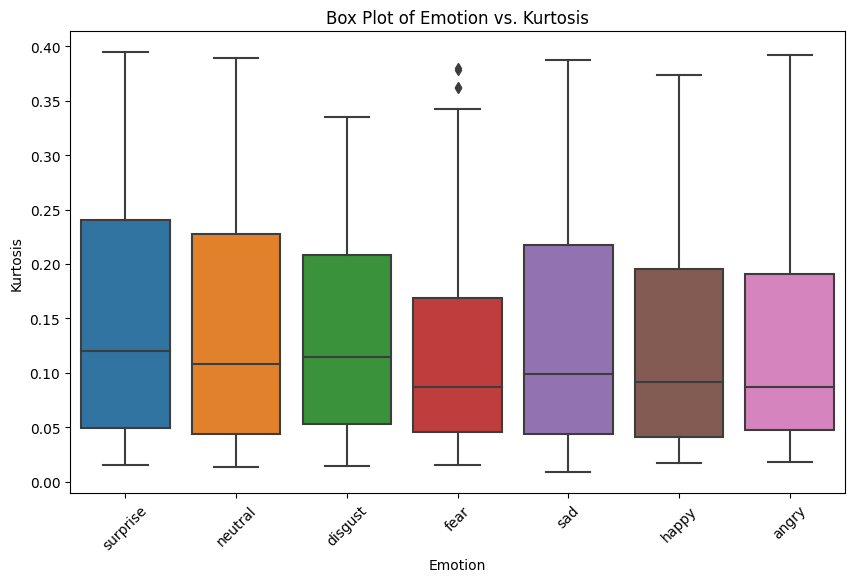

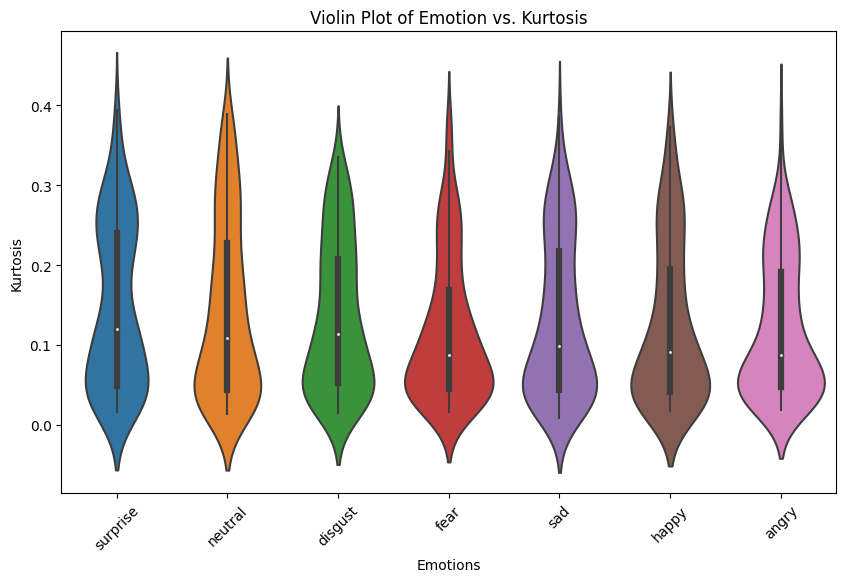

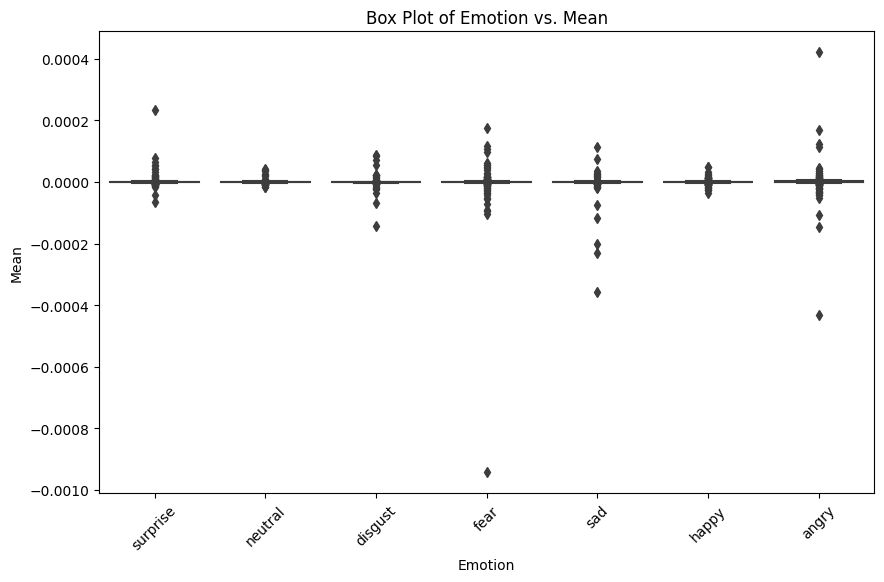

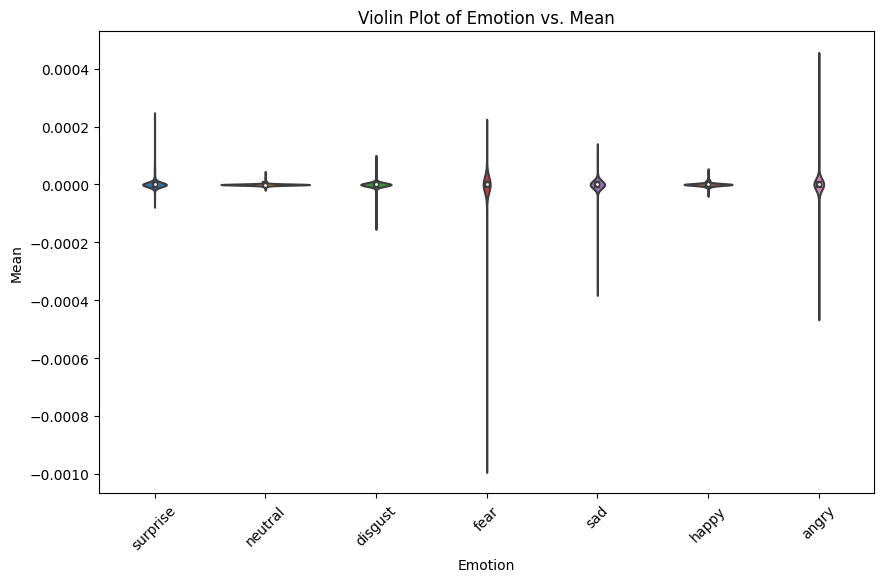

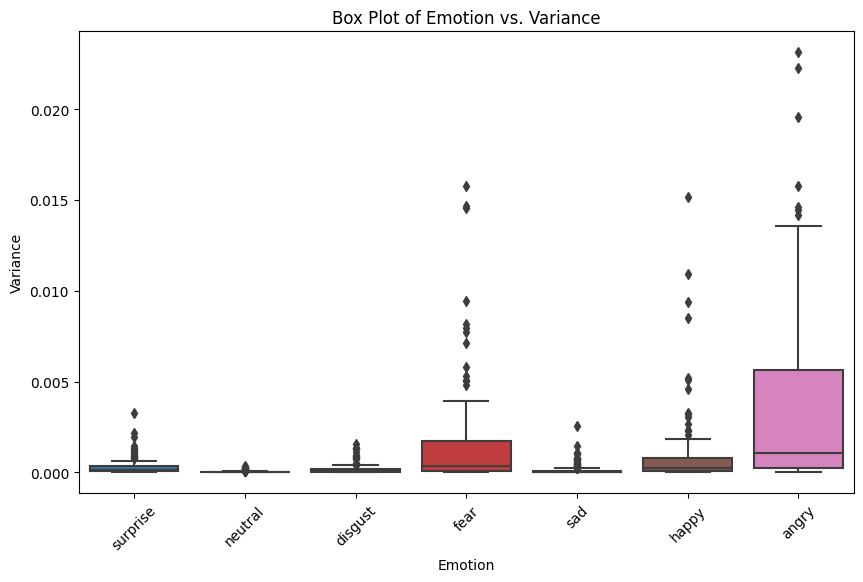

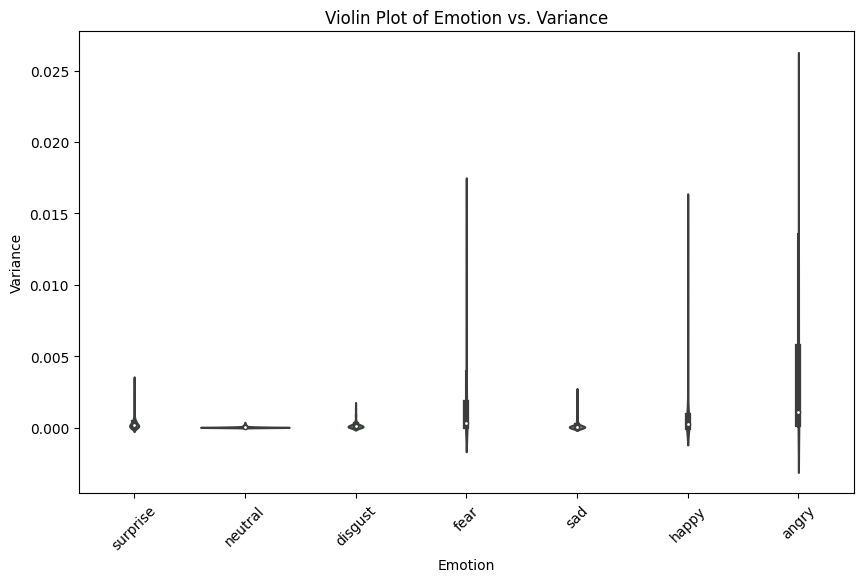

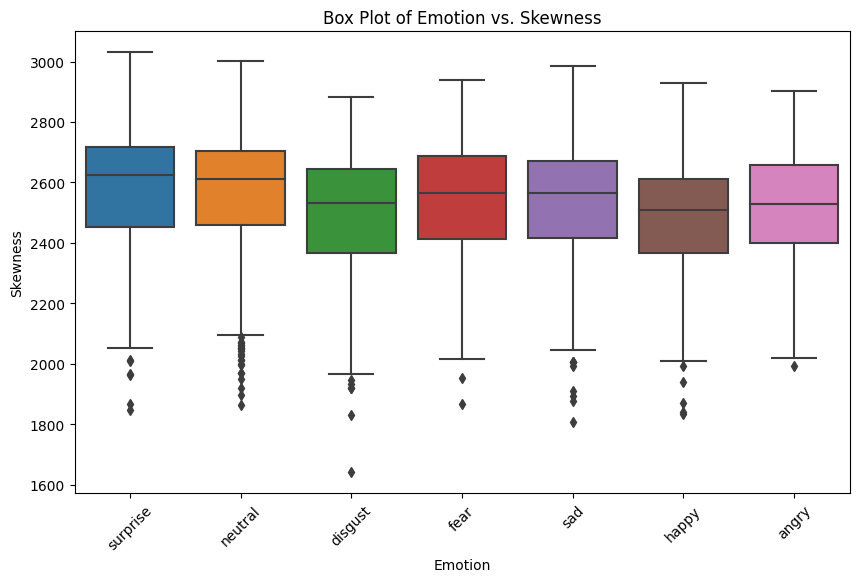

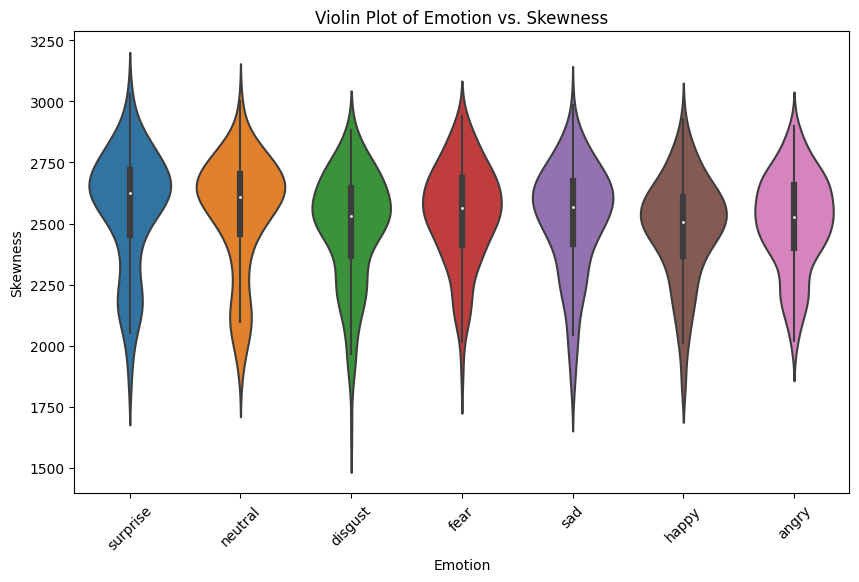

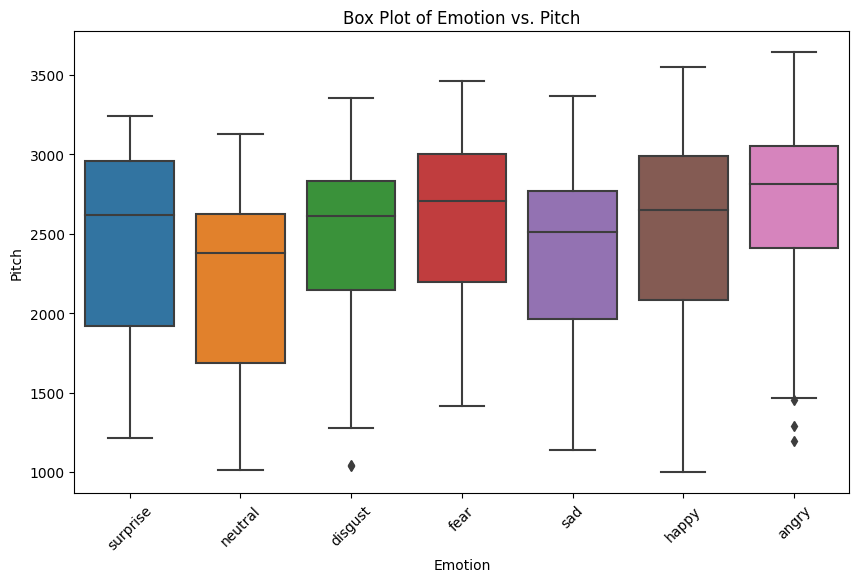

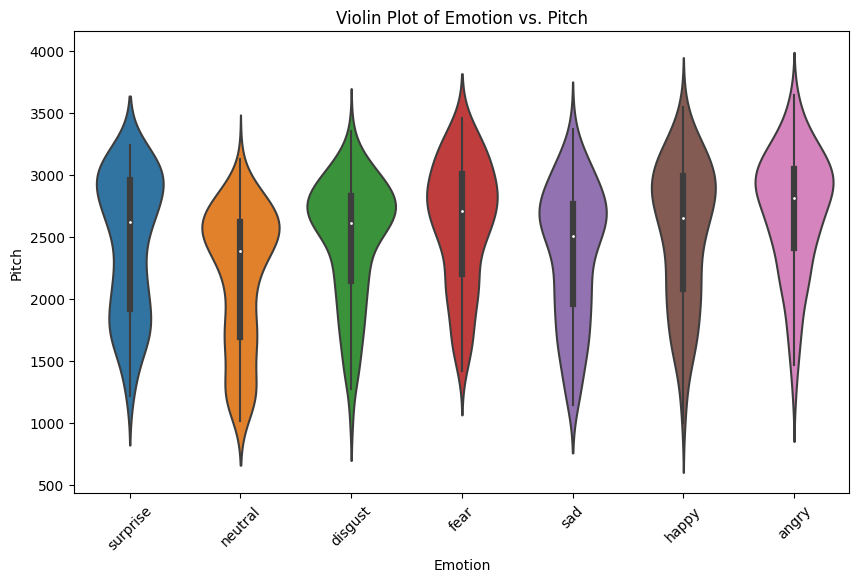

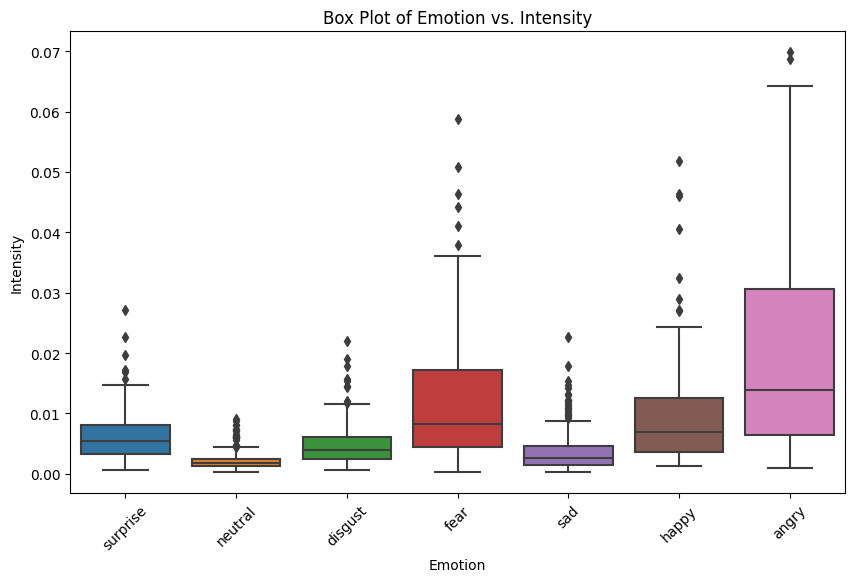

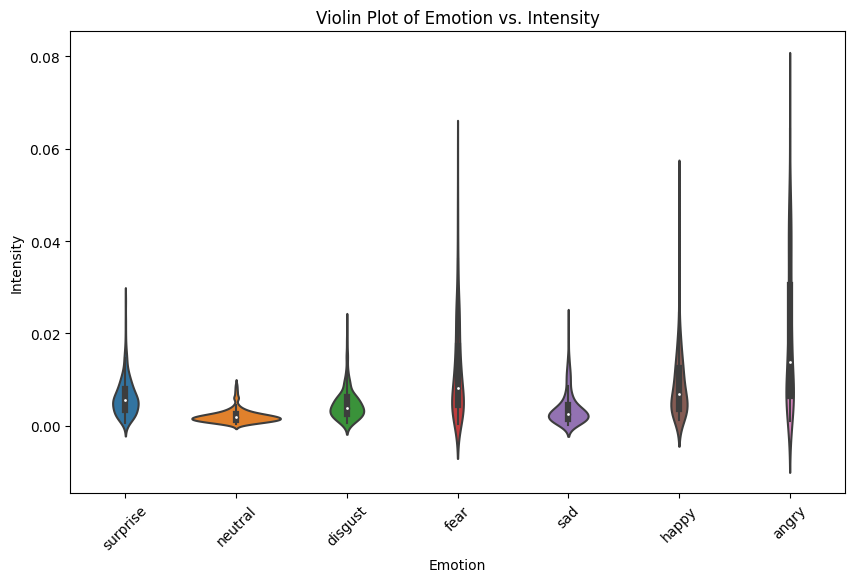

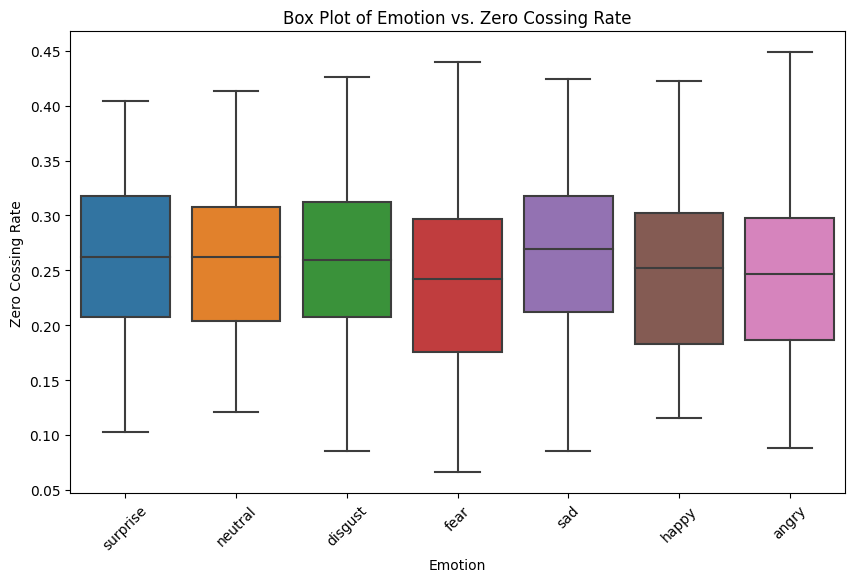

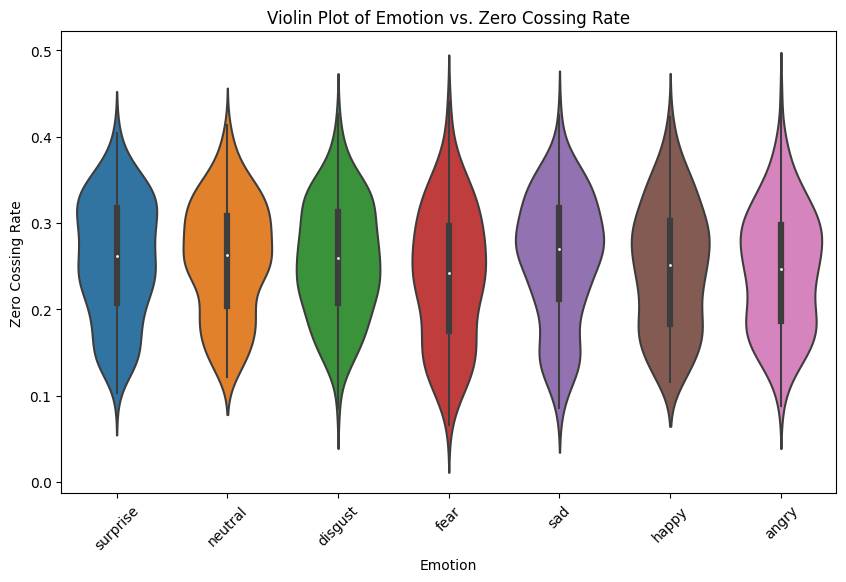

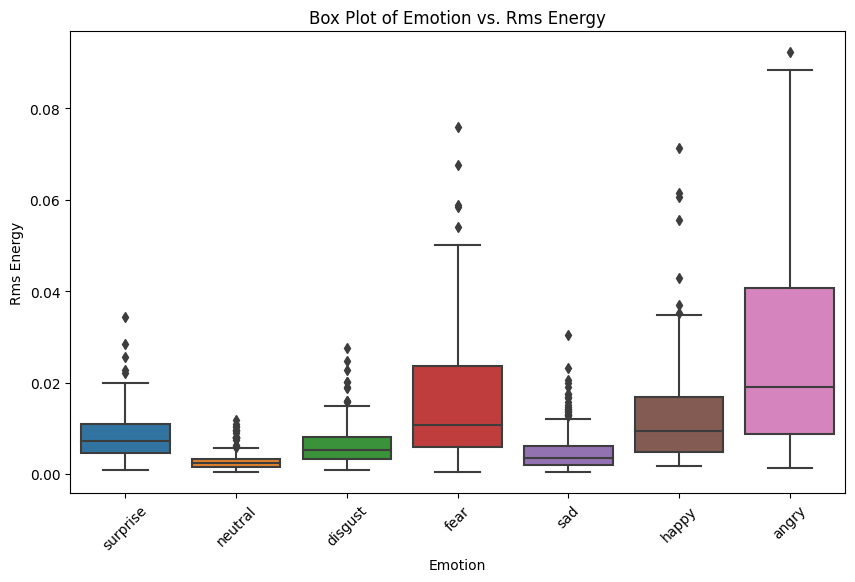

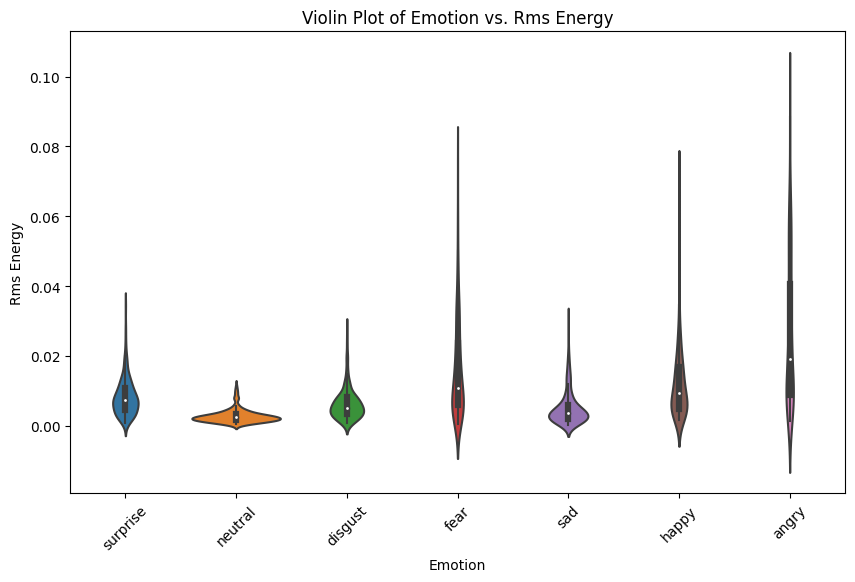

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='kurtosis', data=data)
plt.title('Box Plot of Emotion vs. Kurtosis')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='kurtosis', data=data)
plt.title('Violin Plot of Emotion vs. Kurtosis')
plt.xlabel('Emotions')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='mean', data=data)
plt.title('Box Plot of Emotion vs. Mean')
plt.xlabel('Emotion')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='mean', data=data)
plt.title('Violin Plot of Emotion vs. Mean')
plt.xlabel('Emotion')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()


# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='variance', data=data)
plt.title('Box Plot of Emotion vs. Variance')
plt.xlabel('Emotion')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='variance', data=data)
plt.title('Violin Plot of Emotion vs. Variance')
plt.xlabel('Emotion')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()


# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='skewness', data=data)
plt.title('Box Plot of Emotion vs. Skewness')
plt.xlabel('Emotion')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='skewness', data=data)
plt.title('Violin Plot of Emotion vs. Skewness')
plt.xlabel('Emotion')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='pitch', data=data)
plt.title('Box Plot of Emotion vs. Pitch')
plt.xlabel('Emotion')
plt.ylabel('Pitch')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='pitch', data=data)
plt.title('Violin Plot of Emotion vs. Pitch')
plt.xlabel('Emotion')
plt.ylabel('Pitch')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='intensity', data=data)
plt.title('Box Plot of Emotion vs. Intensity')
plt.xlabel('Emotion')
plt.ylabel('Intensity')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='intensity', data=data)
plt.title('Violin Plot of Emotion vs. Intensity')
plt.xlabel('Emotion')
plt.ylabel('Intensity')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='zero_crossing_rate', data=data)
plt.title('Box Plot of Emotion vs. Zero Cossing Rate')
plt.xlabel('Emotion')
plt.ylabel('Zero Cossing Rate')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='zero_crossing_rate', data=data)
plt.title('Violin Plot of Emotion vs. Zero Cossing Rate')
plt.xlabel('Emotion')
plt.ylabel('Zero Cossing Rate')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='rms_energy', data=data)
plt.title('Box Plot of Emotion vs. Rms Energy')
plt.xlabel('Emotion')
plt.ylabel('Rms Energy')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='rms_energy', data=data)
plt.title('Violin Plot of Emotion vs. Rms Energy')
plt.xlabel('Emotion')
plt.ylabel('Rms Energy')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameters for each model
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    'LightGBM': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
}

# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}

# Initialize GridSearchCV objects for hyperparameter tuning
grid_searches = {}
for name, model in models.items():
    param_grid_model = param_grid.get(name, {})  # Get hyperparameters for the current model
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_model, scoring='accuracy', cv=5, n_jobs=-1)
    grid_searches[name] = grid_search

# Training and evaluating each model with hyperparameter tuning
for name, grid_search in grid_searches.items():
    start_time = time.time()
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    
    train_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Best Params = {grid_search.best_params_}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression: Best Params = {'C': 1}, Accuracy = 0.4479, Precision = 0.4354, Recall = 0.4479, F1 Score = 0.4364, Training Time = 57.8086 s
Decision Tree: Best Params = {'max_depth': 20, 'min_samples_split': 10}, Accuracy = 0.3264, Precision = 0.3406, Recall = 0.3264, F1 Score = 0.3289, Training Time = 22.0034 s
Random Forest: Best Params = {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}, Accuracy = 0.4653, Precision = 0.4208, Recall = 0.4653, F1 Score = 0.4238, Training Time = 256.4266 s
KNN: Best Params = {'n_neighbors': 3}, Accuracy = 0.3299, Precision = 0.3307, Recall = 0.3299, F1 Score = 0.3090, Training Time = 0.6347 s


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameters for each model
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    'LightGBM': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
}

# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}

# Initialize GridSearchCV objects for hyperparameter tuning
grid_searches = {}
for name, model in models.items():
    param_grid_model = param_grid.get(name, {})  # Get hyperparameters for the current model
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_model, scoring='accuracy', cv=5, n_jobs=-1)
    grid_searches[name] = grid_search

# Training and evaluating each model with hyperparameter tuning
for name, grid_search in grid_searches.items():
    start_time = time.time()
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    
    train_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Best Params = {grid_search.best_params_}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

Logistic Regression: Best Params = {'C': 1}, Accuracy = 0.4479, Precision = 0.4354, Recall = 0.4479, F1 Score = 0.4364, Training Time = 55.1502 s
Decision Tree: Best Params = {'max_depth': 10, 'min_samples_split': 5}, Accuracy = 0.3194, Precision = 0.3292, Recall = 0.3194, F1 Score = 0.3218, Training Time = 22.0337 s
Random Forest: Best Params = {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}, Accuracy = 0.4653, Precision = 0.4369, Recall = 0.4653, F1 Score = 0.4270, Training Time = 254.2907 s
KNN: Best Params = {'n_neighbors': 3}, Accuracy = 0.3299, Precision = 0.3307, Recall = 0.3299, F1 Score = 0.3090, Training Time = 0.6504 s


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameters for each model
param_grid = {
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
    'LightGBM': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
}

# Initialize models with default parameters
models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}

# Initialize GridSearchCV objects for hyperparameter tuning
grid_searches = {}
for name, model in models.items():
    param_grid_model = param_grid.get(name, {})  # Get hyperparameters for the current model
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_model, scoring='accuracy', cv=5, n_jobs=-1)
    grid_searches[name] = grid_search

# Training and evaluating each model with hyperparameter tuning
for name, grid_search in grid_searches.items():
    start_time = time.time()
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    
    train_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Best Params = {grid_search.best_params_}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s')


Gradient Boosting: Best Params = {'learning_rate': 0.1, 'n_estimators': 200}, Accuracy = 0.5000, Precision = 0.4995, Recall = 0.5000, F1 Score = 0.4951, Training Time = 6736.8479 s
XGBoost: Best Params = {'learning_rate': 0.1, 'n_estimators': 200}, Accuracy = 0.5243, Precision = 0.5172, Recall = 0.5243, F1 Score = 0.5098, Training Time = 4165.4136 s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350772
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 1448
[LightGBM] [Info] Start training from score -1.989178
[LightGBM] [Info] Start training from score -2.054775
[LightGBM] [Info] Start training from score -1.973430
[LightGBM] [Info] Start training from score -2.029669
[LightGBM] [Info] Start training from score -1.615974
[LightGBM] [Info] Start training from score -1.989178
[LightGBM] [Info] Start training 

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Load CSV data
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Extract features and labels
X = data.drop('Emotions', axis=1).values
y = data['Emotions'].values

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standard scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=np.unique(y_train).size, activation='softmax'))  # Adjust units based on number of unique labels

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Start training time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# End training time
training_time = time.time() - start_time

# Predictions
start_prediction_time = time.time()
y_pred = model.predict_classes(X_test)
prediction_time = time.time() - start_prediction_time

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Training Time:", training_time)
print("Prediction Time:", prediction_time)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1827 - loss: 1.9422 - val_accuracy: 0.2078 - val_loss: 1.9420
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2292 - loss: 1.9107 - val_accuracy: 0.2121 - val_loss: 1.9359
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2292 - loss: 1.9037 - val_accuracy: 0.2381 - val_loss: 1.9535
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2556 - loss: 1.8512 - val_accuracy: 0.2338 - val_loss: 1.9207
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2656 - loss: 1.8466 - val_accuracy: 0.2424 - val_loss: 1.9354
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2519 - loss: 1.8535 - val_accuracy: 0.2554 - val_loss: 1.9325
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2836 - loss: 1.8275 - val_accuracy: 0.2771 - val_loss: 1.8842
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2810 - loss: 1.8291 - val_accuracy: 0.2641 - val_loss:

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [5]:
# Convert probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Training Time:", training_time)
print("Prediction Time:", prediction_time)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.3134 - loss: 1.9383
Test Metrics:
Accuracy: 0.3229166567325592
Precision: 0.2615872844537565
Recall: 0.2886746577708749
F1 Score: 0.2648667380876197
Training Time: 1681.3023154735565
Prediction Time: 4.2574334144592285


In [18]:
from sklearn.preprocessing import LabelEncoder

# Load CSV data
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Extract features (X_speech) and labels (y_speech)
X_speech = data.drop('Emotions', axis=1).values
y_speech = data['Emotions'].values

# Use LabelEncoder to convert categorical labels to integers
label_encoder = LabelEncoder()
y_speech_encoded = label_encoder.fit_transform(y_speech)

# Reshape input features for EfficientNetB0 model
X_speech = X_speech.reshape(-1, 25, 61, 1)  # Reshape to 25x61x1

# Pad the images to make them 25x64x3
X_speech = np.pad(X_speech, ((0, 0), (0, 0), (0, 3), (0, 0)), mode='constant', constant_values=0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_speech, y_speech_encoded, test_size=0.2, random_state=42)

# Resize input images to meet the minimum size requirement of EfficientNetB0
X_train_resized = tf.image.resize(X_train, size=(32, 32))
X_test_resized = tf.image.resize(X_test, size=(32, 32))

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Assuming 8 emotions to classify
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Start training time
start_time = time.time()

# Train the model
history = model.fit(X_train_resized, y_train, epochs=50, batch_size=32, validation_split=0.2)

# End training time
training_time = time.time() - start_time

# Predictions
start_prediction_time = time.time()
y_pred = np.argmax(model.predict(X_test_resized), axis=-1)
prediction_time = time.time() - start_prediction_time

# Evaluate the model
loss, accuracy = model.evaluate(X_test_resized, y_test)
print("Test Accuracy:", accuracy)

# Calculate additional metrics
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print metrics
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Training Time:", training_time)
print("Prediction Time:", prediction_time)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.2092 - loss: 2.0460 - val_accuracy: 0.3203 - val_loss: 1.8197
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2422 - loss: 1.9324 - val_accuracy: 0.2944 - val_loss: 1.7862
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2627 - loss: 1.8472 - val_accuracy: 0.3290 - val_loss: 1.7756
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2643 - loss: 1.8111 - val_accuracy: 0.3160 - val_loss: 1.7577
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2902 - loss: 1.7931 - val_accuracy: 0.3160 - val_loss: 1.7387
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3240 - loss: 1.7416 - val_accuracy: 0.2987 - val_loss: 1.8149
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2577 - loss: 1.8243 - val_accuracy: 0.3247 - val_loss: 1.7436
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3041 - loss: 1.7609 - val_accuracy: 0.2987 -

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping

# Load CSV data
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Extract features (X_speech) and labels (y_speech)
X_speech = data.drop('Emotions', axis=1).values
y_speech = data['Emotions'].values

# Use LabelEncoder to convert categorical labels to integers
label_encoder = LabelEncoder()
y_speech_encoded = label_encoder.fit_transform(y_speech)

# Reshape input features for EfficientNetB0 model
X_speech = X_speech.reshape(-1, 25, 61, 1)  # Reshape to 25x61x1

# Pad the images to make them 25x64x3
X_speech = np.pad(X_speech, ((0, 0), (0, 0), (0, 3), (0, 0)), mode='constant', constant_values=0)

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Define K-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each fold
for train_index, test_index in kfold.split(X_speech, y_speech_encoded):
    X_train, X_test = X_speech[train_index], X_speech[test_index]
    y_train, y_test = y_speech_encoded[train_index], y_speech_encoded[test_index]

    # Resize input images to meet the minimum size requirement of EfficientNetB0
    X_train_resized = tf.image.resize(X_train, size=(32, 32))
    X_test_resized = tf.image.resize(X_test, size=(32, 32))

    # Load pre-trained EfficientNetB0 model
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')  # Assuming 8 emotions to classify
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train_resized, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Predictions
    y_pred = np.argmax(model.predict(X_test_resized), axis=-1)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Calculate average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

print("Average Test Accuracy:", avg_accuracy)
print("Average Test Precision:", avg_precision)
print("Average Test Recall:", avg_recall)
print("Average Test F1 Score:", avg_f1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step
Average Test Accuracy: 0.33125
Average Test Precision: 0.1867631529901724
Average Test Recall: 0.29082454145975023
Average Test F1 Score: 0.21064319007095428


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ERANNs: Efficient Residual Audio Neural Networks for Audio Pattern Recognition

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
import time

# Load features from CSV
def load_data_from_csv(csv_file):
    data = pd.read_csv(csv_file)
    X = data.drop('Emotions', axis=1).values
    y = data['Emotions'].values
    return X, y

# Load the dataset
X, y = load_data_from_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Convert labels to one-hot encoding
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the ERANN model
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and calculate training time
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))
training_time = time.time() - start_time

# Evaluate the model
start_time = time.time()
y_pred = model.predict(X_test)
prediction_time = time.time() - start_time

# Convert predictions to classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

# Print evaluation metrics and timing
print("Test Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Training Time:", training_time)
print("Prediction Time:", prediction_time)


2024-04-25 15:39:59.269205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 15:39:59.269323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 15:39:59.416579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1534 - loss: 331.1262 - val_accuracy: 0.1910 - val_loss: 7.6704
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1531 - loss: 54.2759 - val_accuracy: 0.1597 - val_loss: 2.0560
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1392 - loss: 16.9739 - val_accuracy: 0.1215 - val_loss: 1.9738
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1369 - loss: 10.0092 - val_accuracy: 0.1285 - val_loss: 1.9891
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1420 - loss: 6.5043 - val_accuracy: 0.1562 - val_loss: 1.9775
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1577 - loss: 5.2413 - val_accuracy: 0.1424 - val_loss: 1.9662
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1545 - loss: 4.2183 - val_accuracy: 0.1389 - val_loss: 1.9495
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1618 - loss: 3.2098 - val_accuracy: 0.1389 - val_los

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
!pip install --upgrade librosa

LR MOdels

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
# Initializing models
models = {
    
    'Logistic Regression0': LogisticRegression(max_iter=1000, penalty= "l2"),
    #'Logistic Regression': LogisticRegression(max_iter=1000,  penalty= "elasticnet"),
    'Logistic Regression1': LogisticRegression(max_iter=1000,  penalty= "none"),
    'Logistic Regression2': LogisticRegression(max_iter=1000, solver= "liblinear", penalty= "l1" ),
    'Logistic Regression3': LogisticRegression(max_iter=1000, solver= "liblinear", penalty= "l2"),
    'Logistic Regression4': LogisticRegression(max_iter=1000, solver= "newton-cg", penalty= "l2"),
    'Logistic Regression5': LogisticRegression(max_iter=1000, solver= "newton-cg", penalty= "none"),
    'Logistic Regression6': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty= "l2"),
    'Logistic Regression7': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty= "none"),
    'Logistic Regression8': LogisticRegression(max_iter=1000, solver="sag", penalty= "l2"),
    'Logistic Regression9': LogisticRegression(max_iter=1000, solver="sag", penalty= "none"),
    'Logistic Regression10': LogisticRegression(max_iter=1000, solver="saga", penalty= "l2"),
    'Logistic Regression11': LogisticRegression(max_iter=1000, solver="saga", penalty= "elasticnet"),
    'Logistic Regression12': LogisticRegression(max_iter=1000, solver="saga", penalty= "l1"),
    'Logistic Regression13': LogisticRegression(max_iter=1000, solver="saga", penalty= "none"),
    'Logistic Regression14': LogisticRegression(max_iter=1000, class_weight = "balanced"),
    'Logistic Regression15': LogisticRegression(max_iter=1000, C = 10),
    'Logistic Regression16': LogisticRegression(max_iter=1000, C = 0.001),
    'Logistic Regression17': LogisticRegression(max_iter=1000, C = 0.1),
}


# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-04-25 17:11:58.965310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 17:11:58.965495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 17:11:59.122319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for a

Logistic Regression0: Accuracy = 0.3403, Precision = 0.3132, Recall = 0.3403, F1 Score = 0.3101, Training Time = 16.0560 s, Prediction Time = 0.1024 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression1: Accuracy = 0.3542, Precision = 0.3378, Recall = 0.3542, F1 Score = 0.3332, Training Time = 17.6035 s, Prediction Time = 0.1294 s
Logistic Regression2: Accuracy = 0.2882, Precision = 0.2866, Recall = 0.2882, F1 Score = 0.2820, Training Time = 283.9463 s, Prediction Time = 0.0457 s
Logistic Regression3: Accuracy = 0.2917, Precision = 0.2858, Recall = 0.2917, F1 Score = 0.2841, Training Time = 217.6843 s, Prediction Time = 0.0454 s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Logistic Regression4: Accuracy = 0.3160, Precision = 0.3115, Recall = 0.3160, F1 Score = 0.3073, Training Time = 801.3248 s, Prediction Time = 0.0829 s
Logistic Regression5: Accuracy = 0.3160, Precision = 0.3131, Recall = 0.3160, F1 Score = 0.3080, Training Time = 137.5239 s, Prediction Time = 0.0869 s
Logistic Regression6: Accuracy = 0.2812, Precision = 0.2775, Recall = 0.2812, F1 Score = 0.2765, Training Time = 33.9625 s, Prediction Time = 0.1042 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sc

Logistic Regression7: Accuracy = 0.3576, Precision = 0.3471, Recall = 0.3576, F1 Score = 0.3414, Training Time = 15.8472 s, Prediction Time = 0.0802 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Logistic Regression8: Accuracy = 0.3403, Precision = 0.3090, Recall = 0.3403, F1 Score = 0.3054, Training Time = 77.4107 s, Prediction Time = 0.0418 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression9: Accuracy = 0.3403, Precision = 0.3090, Recall = 0.3403, F1 Score = 0.3054, Training Time = 77.4510 s, Prediction Time = 0.0459 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression10: Accuracy = 0.3333, Precision = 0.2900, Recall = 0.3333, F1 Score = 0.2920, Training Time = 92.4480 s, Prediction Time = 0.0400 s


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
# Initializing models
models = {
#     'Logistic Regression0': LogisticRegression(max_iter=1000, penalty="l2"),
#     'Logistic Regression1': LogisticRegression(max_iter=1000, penalty="none"),
#     'Logistic Regression2': LogisticRegression(max_iter=1000, solver="liblinear", penalty="l1"),
#     'Logistic Regression3': LogisticRegression(max_iter=1000, solver="liblinear", penalty="l2"),
#     'Logistic Regression4': LogisticRegression(max_iter=1000, solver="newton-cg", penalty="l2"),
#     'Logistic Regression5': LogisticRegression(max_iter=1000, solver="newton-cg", penalty="none"),
#     'Logistic Regression6': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty="l2"),
#     'Logistic Regression7': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty="none"),
#     'Logistic Regression8': LogisticRegression(max_iter=1000, solver="sag", penalty="l2"),
#     'Logistic Regression9': LogisticRegression(max_iter=1000, solver="sag", penalty="none"),
#     'Logistic Regression10': LogisticRegression(max_iter=1000, solver="saga", penalty="l2"),
    'Logistic Regression11': LogisticRegression(max_iter=1000, solver="saga", penalty="elasticnet", l1_ratio=0.5),
    'Logistic Regression12': LogisticRegression(max_iter=1000, solver="saga", penalty="l1"),
    'Logistic Regression13': LogisticRegression(max_iter=1000, solver="saga", penalty="none"),
    'Logistic Regression14': LogisticRegression(max_iter=1000, class_weight="balanced"),
    'Logistic Regression15': LogisticRegression(max_iter=1000, C=10),
    'Logistic Regression16': LogisticRegression(max_iter=1000, C=0.001),
    'Logistic Regression17': LogisticRegression(max_iter=1000, C=0.1),
}



# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression11: Accuracy = 0.3333, Precision = 0.2900, Recall = 0.3333, F1 Score = 0.2920, Training Time = 228.2699 s, Prediction Time = 0.0385 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Logistic Regression12: Accuracy = 0.3333, Precision = 0.2908, Recall = 0.3333, F1 Score = 0.2918, Training Time = 230.5526 s, Prediction Time = 0.0448 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression13: Accuracy = 0.3333, Precision = 0.2900, Recall = 0.3333, F1 Score = 0.2920, Training Time = 92.0835 s, Prediction Time = 0.0369 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression14: Accuracy = 0.3576, Precision = 0.3521, Recall = 0.3576, F1 Score = 0.3480, Training Time = 16.8856 s, Prediction Time = 0.0763 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression15: Accuracy = 0.3646, Precision = 0.3480, Recall = 0.3646, F1 Score = 0.3434, Training Time = 15.1356 s, Prediction Time = 0.1272 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression16: Accuracy = 0.3542, Precision = 0.3258, Recall = 0.3542, F1 Score = 0.3248, Training Time = 14.5207 s, Prediction Time = 0.1268 s
Logistic Regression17: Accuracy = 0.3403, Precision = 0.3225, Recall = 0.3403, F1 Score = 0.3173, Training Time = 14.9824 s, Prediction Time = 0.0750 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


hyperparameterizatiom for LR

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/ravdesslibrosaextracted/ExtractedFeaturesForRavdessDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'Logistic Regression': {
        'C': [0.001, 0.1, 1, 5, 10], 
        'penalty': ["l1", "l2"], 
        'solver': ["liblinear", "saga"], 
        'max_iter': [1000, 1500, 2000]  # Adjust max_iter values
    }
}

# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(),
}

# Initialize GridSearchCV objects for hyperparameter tuning
grid_searches = {}
for name, model in models.items():
    param_grid_model = param_grid.get(name, {})  # Get hyperparameters for the current model
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_model, scoring='accuracy', cv=5, n_jobs=-1)
    grid_searches[name] = grid_search

# Training and evaluating each model with hyperparameter tuning
for name, grid_search in grid_searches.items():
    start_time = time.time()
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    
    train_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Best Params = {grid_search.best_params_}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/

Logistic Regression: Best Params = {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}, Accuracy = 0.5174, Precision = 0.4973, Recall = 0.5174, F1 Score = 0.5003, Training Time = 5933.6541 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Differemt Models for DT

In [6]:
import os
import pandas as pd
import librosa
import numpy as np
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Function to generate Mel spectrograms from audio files
def generate_mel_spectrogram(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    return mel_spectrogram

# Function to convert Mel spectrograms to images and resize them
def mel_spectrogram_to_image(mel_spectrogram, target_size=(224, 224)):
    mel_spectrogram_image = resize(mel_spectrogram, target_size)
    return mel_spectrogram_image

# Function to extract features from Mel spectrogram images using VGG16
def extract_features_from_mel_spectrogram_image(mel_spectrogram_image):
    # Convert the 2D image to 3D with a single channel
    mel_spectrogram_image_rgb = np.stack((mel_spectrogram_image,) * 3, axis=-1)
    # Resize image to VGG16 input size
    resized_image = resize(mel_spectrogram_image_rgb, (224, 224))
    # Preprocess input for VGG16
    preprocessed_input = preprocess_input(resized_image)
    # Expand dimensions to match VGG16 input shape
    input_image = np.expand_dims(preprocessed_input, axis=0)
    # Extract features
    features = feature_extractor.predict(input_image)
    return features

# Load VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False)
feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_pool').output)

# Read CSV file containing classified emotions and paths to audio files
csv_file_path = "/kaggle/working/classified_ravdess.csv"
data = pd.read_csv(csv_file_path)

# Function to extract features and save them to CSV file
def extract_and_save_features(data):
    features_list = []
    for index, row in data.iterrows():
        audio_file_path = row['Path']
        emotion = row['Emotions']
        # Generate Mel spectrogram from audio file
        mel_spectrogram = generate_mel_spectrogram(audio_file_path)
        # Convert Mel spectrogram to image and resize
        mel_spectrogram_image = mel_spectrogram_to_image(mel_spectrogram)
        # Extract features using VGG16
        features = extract_features_from_mel_spectrogram_image(mel_spectrogram_image)
        # Append features, emotion, and path to list
        features_list.append({'Emotions': emotion, 'Path': audio_file_path, 'features': features})
    # Convert features list to DataFrame
    features_df = pd.DataFrame(features_list)
    # Save DataFrame to CSV file
    features_df.to_csv("extracted_features.csv", index=False)

# Call the function to extract features and save them
extract_and_save_features(data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/extracted_features.csv"
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,Emotions,Path,features
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/A...,[[[[0. 0. 0. ... 0. ...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...,[[[[0. 0. 0. ... 0. ...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...,[[[[0. 0. 0. ... 0. ...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...,[[[[0. 0. 0. ... 0. ...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...,[[[[0. 0. 0. ... 0. ...


In [9]:
import pandas as pd

# Read the CSV file into a DataFrame
csv_file_path = "/kaggle/working/extracted_features.csv"
data = pd.read_csv(csv_file_path)

# Print a particular column (e.g., "emotion")
print(data["features"])


0       [[[[0.         0.         0.         ... 0.   ...
1       [[[[0.        0.        0.        ... 0.      ...
2       [[[[0.         0.         0.         ... 0.   ...
3       [[[[0.         0.         0.         ... 0.   ...
4       [[[[0.         0.         0.         ... 0.   ...
                              ...                        
1435    [[[[0.         0.         0.         ... 0.   ...
1436    [[[[0.         0.         0.         ... 0.   ...
1437    [[[[0.         0.         0.         ... 0.   ...
1438    [[[[0.         0.         0.         ... 0.   ...
1439    [[[[0.        0.        0.        ... 0.      ...
Name: features, Length: 1440, dtype: object


Wav2vec Feature Extractio

In [15]:
import os
import torch
import torch.nn as nn
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
from torchaudio.transforms import Resample
import time

class EmotionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wav2vec2 = Wav2Vec2Model(config)

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state.mean(dim=1)
        return hidden_states

def process_func(audio_dir):
    device = 'cpu'
    model_name = 'audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim'
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    model.to(device)

    features_list = []
    paths_list = []

    resampler = Resample(orig_freq=24414, new_freq=16000)

    start_time = time.time()

    for root, dirs, files in os.walk(audio_dir):
        for file in files:
            audio_path = os.path.join(root, file)
            array, fs = torchaudio.load(audio_path)
            array_resampled = resampler(array)
            # Reshape the audio to 1D tensor
            array_resampled = array_resampled.reshape(1, -1)
            input_values = processor(array_resampled.squeeze(), sampling_rate=16000, return_tensors="pt")
            input_values = input_values.input_values.to(device)
            with torch.no_grad():
                hidden_states = model(input_values)
            if isinstance(hidden_states, torch.Tensor):
                hidden_states = hidden_states.mean(dim=1)
                features_list.append(hidden_states.cpu().numpy())  # Convert to NumPy array
                paths_list.append(audio_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Time taken to extract features:", elapsed_time, "seconds")

    return features_list, paths_list

# Example usage:
audio_dir = '/kaggle/input/ravdess-emotional-speech-audio'
features_list, paths_list = process_func(audio_dir)

# Convert lists to DataFrame
data = {'Path': paths_list, 'Features': features_list}
df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_file = '/kaggle/working/wav2vecfeaturesravdess.csv'
df.to_csv(csv_file, index=False)
print("Features saved to:", csv_file)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Time taken to extract features: 6810.239865779877 seconds
Features saved to: /kaggle/working/wav2vecfeaturesravdess.csv


In [19]:
data = pd.read_csv('/kaggle/working/wav2vecfeaturesravdess.csv')
data.head()
#31 mis

,Path,Features


In [5]:
import os
import torch
import torch.nn as nn
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
import numpy as np
import time

class EmotionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wav2vec2 = Wav2Vec2Model(config)

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0)
        return hidden_states

def process_func(audio_dir):
    device = torch.device('cpu')  # Specify device
    model_name = 'audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim'
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    model.to(device)

    features_list = []
    paths_list = []

    start_time = time.time()

    for root, dirs, files in os.walk(audio_dir):
        for file in files:
            audio_path = os.path.join(root, file)
            array, fs = torchaudio.load(audio_path)
            # Resample the audio to match the model's sampling rate (16,000 Hz)
            resampler = torchaudio.transforms.Resample(orig_freq=fs, new_freq=16000)
            array_resampled = resampler(array)
            print("Original audio shape:", array.shape)
            print("Resampled audio shape:", array_resampled.shape)
            input_values = processor(array_resampled.squeeze(), sampling_rate=16000, return_tensors="pt")
            input_values = {k: v.to(device) for k, v in input_values.items()}  # Move input tensors to device
            with torch.no_grad():
                hidden_states = model(**input_values)
            features_list.append(hidden_states.last_hidden_state.squeeze().mean(axis=0).cpu().numpy().tolist())
            paths_list.append(audio_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Time taken to extract features:", elapsed_time, "seconds")

    return features_list, paths_list

# Example usage:
audio_dir = '/kaggle/input/ravdess-emotional-speech-audio/'
features_list, paths_list = process_func(audio_dir)

# Convert lists to DataFrame
data = {'Path': paths_list}
for i in range(len(features_list[0])):
    data[f'Feature_{i}'] = [feature[i] for feature in features_list]

df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_file = '/kaggle/working/featuresforSaveeWav2vec.csv'
df.to_csv(csv_file, index=False)
print("Features saved to:", csv_file)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original audio shape: torch.Size([1, 169769])
Resampled audio shape: torch.Size([1, 56590])
Original audio shape: torch.Size([1, 174574])
Resampled audio shape: torch.Size([1, 58192])
Original audio shape: torch.Size([1, 198598])
Resampled audio shape: torch.Size([1, 66200])
Original audio shape: torch.Size([1, 174575])
Resampled audio shape: torch.Size([1, 58192])
Original audio shape: torch.Size([1, 180980])
Resampled audio shape: torch.Size([1, 60327])
Original audio shape: torch.Size([1, 172973])
Resampled audio shape: torch.Size([1, 57658])
Original audio shape: torch.Size([1, 179379])
Resampled audio shape: torch.Size([1, 59793])
Original audio shape: torch.Size([1, 172973])
Resampled audio shape: torch.Size([1, 57658])
Original audio shape: torch.Size([1, 192192])
Resampled audio shape: torch.Size([1, 64064])
Original audio shape: torch.Size([1, 172973])
Resampled audio shape: torch.Size([1, 57658])
Original audio shape: torch.Size([1, 184184])
Resampled audio shape: torch.Size(

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 2, 67801]

In [22]:
# Print the size of features_list
print("Number of features extracted:", len(features_list))

# Print the contents of features_list (for debugging)
print("Contents of features_list:", features_list)

Number of features extracted: 0
Contents of features_list: []
